In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, CoherenceModel

import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize
import pymorphy2

import nltk
from corus import load_lenta

from tqdm.notebook import tqdm
from multiprocessing import Pool
import pymorphy2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'D:/GeekBrains/nlp/les04/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [3]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [4]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])
data.sample(3)

,title,topic,text,tags
594718,Швейцарка Фриден нарушила гегемонию США в сноу...,Спорт,На Олимпиаде в Турине разыгран второй комплект...,Все
377832,В Индонезии при пожаре на пароме погибли одинн...,Мир,По меньшей мере одиннадцать человек погибли в ...,Все
96467,WP узнала о планах администрации Трампа замени...,Мир,Несколько высокопоставленных сотрудников Госуд...,Политика


In [5]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика             79538
Спорт                 64421
Культура              53803
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44675
Из жизни              27611
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Name: topic, dtype: int64

In [6]:
topics = ['Спорт', 'Культура', 'Бывший СССР', 'Наука и техника', 'Интернет и СМИ']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)

### preprocessing

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt', encoding='utf8') as f:
    additional_stopwords = set([w.strip() for w in f.readlines() if w]) # from https://github.com/stopwords-iso and others
stopword_ru += list(additional_stopwords)
len(stopword_ru)

1150

In [9]:
'год' in stopword_ru

True

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищенный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
def preprocess(text):
    new_text = clean_text(text)
    
    return lemmatization(new_text)

In [12]:
data.text.iloc[1]

'Архиепископ канонической Украинской православной церкви Московского патриархата (УПЦ МП) Лонгин отказался участвовать в «объединительном соборе» по приглашению Вселенского патриарха Варфоломея. Он назвал это мероприятие «собором нечестивых» и «сатанинским сборищем». Об этом говорится в его письме, выдержки из которого публикует «Страна». Священнослужитель подчеркнул, что архиереи УПЦ МП против этого собрания. «Если Вы называете себя Матерью всех Церквей, то почему Вы отдали на поругание наши Православные святыни, на растерзание истинную Православную Церковь наших братьев сослужителей, допустили мучение и пытание священников?» — написал Лонгин. В своем послании он также осудил снятие анафемы с предстоятеля неканонической УПЦ Киевского патриархата Филарета. «То, что произошло на синоде в Стамбуле, шокировало весь Православный мир», — отметил архиепископ. «Объединительный собор», инициированный президентом Украины Петром Порошенко и патриархом Варфоломеем, пройдет 15 декабря в Софийском 

In [13]:
print(preprocess(data.text.iloc[1]))

['архиепископ', 'канонический', 'украинский', 'православный', 'церковь', 'московский', 'патриархат', 'упц', 'мп', 'лонгин', 'отказаться', 'участвовать', 'объединительный', 'собор', 'приглашение', 'вселенский', 'патриарх', 'варфоломей', 'мероприятие', 'собор', 'нечестивый', 'сатанинский', 'сборище', 'письмо', 'выдержка', 'публиковать', 'священнослужитель', 'подчеркнуть', 'архиерей', 'упц', 'мп', 'собрание', 'называть', 'церковь', 'отдать', 'поругание', 'православный', 'святыня', 'растерзание', 'истинный', 'православный', 'церковь', 'брат', 'сослужитель', 'допустить', 'мучение', 'пытание', 'священник', 'написать', 'лонгин', 'послание', 'осудить', 'снятие', 'анафема', 'предстоятель', 'неканонический', 'упц', 'киевский', 'патриархат', 'филарет', 'произойти', 'синод', 'стамбул', 'шокировать', 'православный', 'архиепископ', 'объединительный', 'собор', 'инициировать', 'украина', 'пётр', 'порошенко', 'патриарх', 'варфоломей', 'софийский', 'собор', 'киев', 'передавать', 'риа', 'новость', 'немой

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


In [14]:
data = data.sample(10000)
data.topic.value_counts()

Спорт              2322
Культура           2057
Бывший СССР        1987
Наука и техника    1985
Интернет и СМИ     1649
Name: topic, dtype: int64

In [15]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
368997,Генпрокуратура отпустила Кучму в Москву,Бывший СССР,"[генпрокуратура, украина, разрешить, экспрезид...",Все
46230,Определены лучшие плохие фильмы всех времен,Культура,"[издание, nme, составить, список, великий, пло...",Кино
128605,Глотатель шпаг получил удар горящей стрелой в ...,Интернет и СМИ,"[участник, американский, шоу, талант, america,...",ТВ и радио


### lda

In [17]:
dictionary = Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

In [18]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
MmCorpus.serialize('lenta.model', corpus) 

In [19]:
%time 
lda = LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=2, random_state = 42)

Wall time: 0 ns


In [20]:
# lda.show_topics(num_topics=7, num_words=10, formatted=True)

In [21]:
x = lda.show_topics(num_topics=7, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: тысяча российский решение агентство принять программа телеканал сезон директор депутат
topic_1: матч команда чемпионат сборная счёт клуб игра турнир российский победа
topic_2: учёный исследование обнаружить музей университет опубликовать метр установить модель журнал
topic_3: фильм картина режиссёр роль актёр американский известный премия британский сериал
topic_4: игра доллар миллион проект система сша самолёт миллиард космический американский
topic_5: украина украинский власть партия глава выборы республика российский киев территория
topic_6: сайт сеть пользователь информация закон журналист google канал сервис сотрудник


In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Wall time: 5.08 s


#### metrics

In [23]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  0.0003020956479325436


In [24]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.5802687245873714


### num topics

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

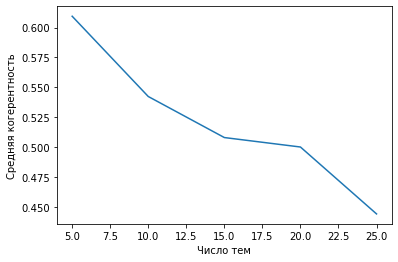

In [25]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2, random_state = 42)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

#### num_topics = 5

In [26]:
lda_5 = LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2, random_state = 42)
vis_data = gensimvis.prepare(lda_5, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
x = lda_5.show_topics(num_topics=5, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: украина глава российский власть украинский решение партия информация агентство выборы
topic_1: матч команда чемпионат сборная клуб счёт игра турнир российский сезон
topic_2: сайт пользователь сеть учёный исследование обнаружить использовать тысяча сервис реклама
topic_3: фильм картина режиссёр американский роль известный актёр британский написать история
topic_4: доллар миллион игра проект сша миллиард самолёт версия космический американский


C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Как помним, из исходного датасета мы взяли как раз 5 тем ['Спорт', 'Культура', 'Бывший СССР', 'Наука и техника', 'Интернет и СМИ']. Получилось довольно похоже